# Context

going through the work of Andrej Karpathys youtube walkthrough of Neural Networks and Backpropagation: [link](https://www.youtube.com/watch?v=VMj-3S1tku0&t=1698s&ab_channel=AndrejKarpathy)

In [66]:
# we build "handcoded" tensors

class Value:

    # init
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children) # for efficiency, stored above as a tuple and then maininting it in the class will be a set
        self._op = _op # op = operation
        self.label = label

    # a way to print the info below in a more "nice" way, would look a bit cryptic without this.
    def __repr__(self):
        return f"Value(data={self.data})"

    # addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    # multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label ='L'
L

Value(data=-8.0)

In [67]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [68]:
d._op

'+'

In [69]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f }" % (n.label, n.data), shape = 'record')

        if n._op:
            #if this values ia result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)

            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

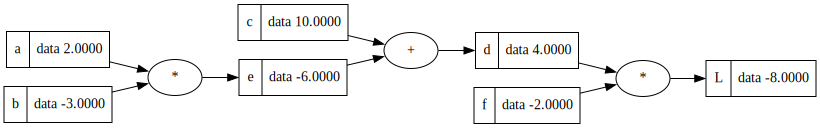

In [70]:
draw_dot(L)

## What is happening in the above graph?
it's basically a forward pass of math expressions, that after doing all of the calculations (+/*) it produces a single output: L (=-8 as of writing this).

Backpropagation = we start at the end (L), and work our way backwards and calculate the gradient along all of these values.

### What will happen at each point when we do backpropagation?
we compute the derivate of each node, with respect to L.

What would that look like, if we want to store the derivative with respect to L?

In [71]:
# we build "handcoded" tensors

class Value:

    # init
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # starting as 0 in initilisation.
        self._prev = set(_children) # for efficiency, stored above as a tuple and then maininting it in the class will be a set
        self._op = _op # op = operation
        self.label = label

    # a way to print the info below in a more "nice" way, would look a bit cryptic without this.
    def __repr__(self):
        return f"Value(data={self.data})"

    # addition
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    # multiplication
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out



a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label ='L'
L

Value(data=-8.0)

In [72]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        #for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')

        if n._op:
            #if this values ia result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)

            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

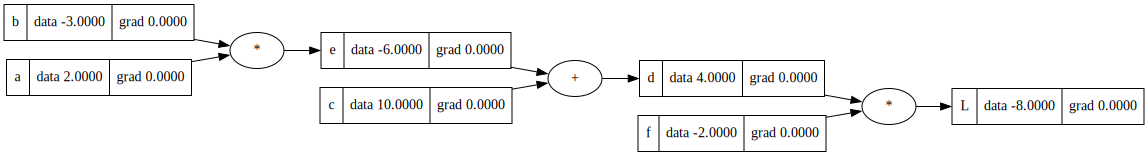

In [73]:
draw_dot(L)

## Let's now fill in the gradients and do the backpropogation manually: 

if we took a look numerically and estimated the grad for L with respect to L:

In [75]:
def testing():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label ='L'
    L1 = L.data

    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label ='L'
    L2 = L.data + h # we add h to check the gradient here:

    #gradient:
    print((L2 - L1) / h )

testing()

0.9999999999976694


which makes sense, that it's =1 because the derivate of L with respect to L is = 1. 

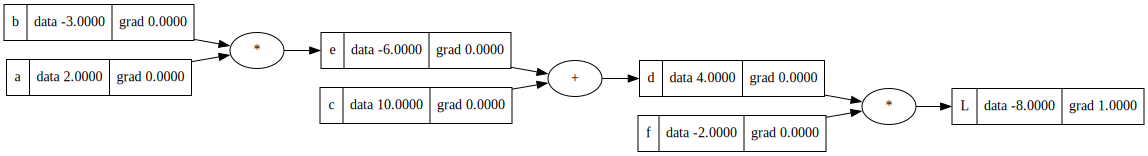

In [77]:
# let set the first one = 1 as we now know the gradient: 
L.grad = 1.0

# draw it out: 
draw_dot(L)

Now let's do L with repect to d and f, and start with d first:

L = d * f

----> dL/dd = f

deriving this: using function from wiki of how to estimate the derivative:

(f(d+h)*f - d*f)/h

The above becomes:

(d*f + h*f - d*f)/ h

the d*f cancels out the - d*f, so it becomes :

h*f / h

which is = f

### now: 
using the above logic, we can see that it goes in the same way when we take L with respect to f = **d**

which means that the: 
* derivative of L with respect to d = 4.0
* derivative of L with respect to f = -2.0

In [78]:
f.grad = 4.0
d.grad = -2.0

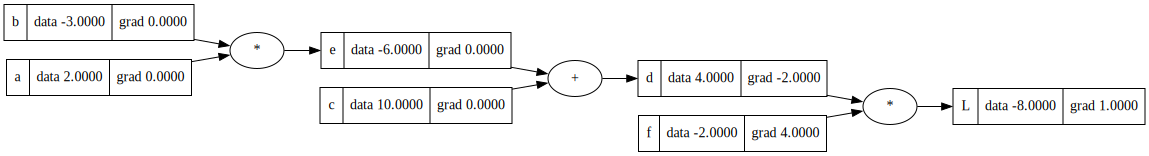

In [79]:
# draw it out: 
draw_dot(L)

### Let's double check that this checks out:
we estimated that the derivative of dl by dd is = -2.0, so let's check that:

In [80]:
def testing():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label ='L'
    L1 = L.data

    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f') # adding h here to check that the output of the derivative is = 4
    L = d * f; L.label ='L'
    L2 = L.data

    #gradient:
    print((L2 - L1) / h )

testing()

3.9999999999995595


#### Looks correct :) 

# NOW THIS IS THE MOST IMPORANT THING TO UNDERSTAND BACKPROPAGATION FOR NNs:
@38:20 in the video: 

## which is: deriving the derivative of L, with respect to c
= *dL / dc*